<h1>Predikcia počtu obetí</h1>

<h4>Naimportovanie knižníc</h4>

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


<h4>Načítanie datasetu</h4>

In [127]:
# Načítanie datasetu
df = pd.read_csv("us_tornado_dataset_1950_2021.csv")

<h4>Úprava datasetu</h4>

In [128]:
# Odstránenie stĺpca 'date' z DataFrame 'df'
df.drop(['date'], axis=1, inplace=True)
# Odstránenie riadkov s hodnotou 'mag' rovnou -9 z DataFrame 'df'
df = df[df['mag'] != -9]
# Vytvorenie stĺpca 'wid_c' pomocou kvartilového rozdelenia stĺpca 'wid'
df['wid_c'] = pd.qcut(df['wid'], q=4, labels=['small', 'medium', 'large', 'extreme'])
# Vytvorenie stĺpca 'len_c' pomocou kvartilového rozdelenia stĺpca 'len'
df['len_c'] = pd.qcut(df['len'], q=4, labels=['short', 'medium', 'long', 'extreme'])
# Vytvorenie binárneho stĺpca 'fat_bin' na základe podmienky stĺpca 'fat'
df['fat_bin'] = df['fat'].apply(lambda x: 1 if x > 0 else 0)
# Odstránenie stĺpcov 'elat' a 'elon' z DataFrame 'df'
df.drop(['elat', 'elon'], axis=1, inplace=True)

<h4>Funkcia pre výpočet priemernej dĺžky a širky</h4>

In [129]:
def calculate_mean_values_before_encoding(train_df):
     # Vypočítanie priemerných hodnôt atribútu 'len' pre rôzne hodnoty atribútu 'mag'
    avg_len_by_mag = train_df[train_df['len'] != 0].groupby('mag')['len'].mean()
    # Vypočítanie priemerných hodnôt atribútu 'wid' pre rôzne hodnoty atribútu 'mag'
    avg_wid_by_mag = train_df[train_df['wid'] != 0].groupby('mag')['wid'].mean()
    
    # Vrátenie vypočítaných priemerných hodnôt
    return avg_len_by_mag, avg_wid_by_mag

<h4>Funkcia pre nahradenie chýbajúcich hodnôt priemerom</h4>

In [130]:
def preprocess_data(train_df, avg_len_by_mag, avg_wid_by_mag):
    # Pretypovanie stĺpca 'wid' na dátový typ float64
    train_df['wid'] = train_df['wid'].astype(np.float64)
    # Nahradenie nulových hodnôt atribútu 'len' priemerom podľa hodnoty atribútu 'mag'
    train_df.loc[train_df['len'] == 0, 'len'] = train_df.loc[train_df['len'] == 0, 'mag'].map(avg_len_by_mag)
    # Nahradenie nulových hodnôt atribútu 'wid' priemerom podľa hodnoty atribútu 'mag'
    train_df.loc[train_df['wid'] == 0, 'wid'] = train_df.loc[train_df['wid'] == 0, 'mag'].map(avg_wid_by_mag)
    # Vytvorenie kategorického stĺpca 'wid_c' pomocou kvartilového rozdelenia atribútu 'wid', pretože niektoré hodnoty boli nahradené
    train_df['wid_c'] = pd.qcut(train_df['wid'], q=4, labels=['small', 'medium', 'large', 'extreme'])
    # Vytvorenie kategorického stĺpca 'len_c' pomocou kvartilového rozdelenia atribútu 'len', pretože niektoré hodnoty boli nahradené
    train_df['len_c'] = pd.qcut(train_df['len'], q=4, labels=['short', 'medium', 'long', 'extreme'])
    
    # Vrátenie upraveného DataFrame 'train_df'
    return train_df

<h4>Funkcia pre RandomOverSampler</h4>

In [131]:
def balance_random(train_df, target_column='mag', random_state=42):
    # Oddelenie cieľového atribútu od funkcií
    X_train = train_df.drop(columns=[target_column])
    y_train = train_df[target_column]

    # Inicializácia a aplikácia RandomOverSampleru na trénovací dataset
    oversampler = RandomOverSampler(random_state=random_state)
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

    # Vytvorenie DataFrame z vyvážených údajov
    train_df = pd.DataFrame(X_resampled, columns=X_train.columns)
    train_df[target_column] = y_resampled

    return train_df

<h4>Funkcia pre SMOTE</h4>

In [132]:
def balance_smote(train_df, target_column='mag', random_state=42):
    # Oddelenie cieľového atribútu od funkcií
    X_train = train_df.drop(columns=[target_column])
    y_train = train_df[target_column]

    # Inicializácia a aplikácia SMOTE na trénovací dataset
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Vytvorenie DataFrame z vyvážených údajov
    train_df = pd.DataFrame(X_resampled, columns=X_train.columns)
    train_df[target_column] = y_resampled

    return train_df

<h4>Funkcia pre RandomUnderSampler</h4>

In [133]:
def balance_undersample(train_df, target_column='mag', random_state=42):
    # Oddelenie cieľového atribútu od funkcií
    X_train = train_df.drop(columns=[target_column])
    y_train = train_df[target_column]

    # Inicializácia a aplikácia RandomUnderSampleru na trénovací dataset
    undersampler = RandomUnderSampler(random_state=random_state)
    X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

    # Vytvorenie DataFrame z vyvážených údajov
    train_df = pd.DataFrame(X_resampled, columns=X_train.columns)
    train_df[target_column] = y_resampled

    return train_df

<h4>Funkcia pre prevedenie kategorických atribútov na číselné</h4>

In [134]:
# Definícia funkcie na prevedenie kategorických atribútov na číselné pomocou one-hot encoding
def one_hot_encode(df, columns):
    
    return pd.get_dummies(df, columns=columns, drop_first=True)

<h4>Použitie funkcií</h4>

In [135]:
# Vypočítanie priemerných hodnôt 'len' a 'wid' pre rôzne hodnoty 'mag'
avg_len_by_mag, avg_wid_by_mag = calculate_mean_values_before_encoding(df)
# Rozdelenie datasetu na trénovaciu a testovaciu sadu s 20% dátami pre testovanie
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['wid_c'])
# Predspracovanie trénovacieho datasetu s použitím priemerných hodnôt 'len' a 'wid'
train_df = preprocess_data(train_df, avg_len_by_mag, avg_wid_by_mag)

In [136]:
# Zakódovanie kategorických stĺpcov v testovacej sade
test_df = one_hot_encode(test_df, columns=['st', 'wid_c', 'len_c'])
# Zakódovanie kategorických stĺpcov v trénovacej sade
train_df = one_hot_encode(train_df, columns=['st', 'wid_c', 'len_c'])

In [137]:
# Vytvorenie vyvážených trénovacích sád
smote_train_df = balance_smote(train_df)
balance_train_df = balance_random(train_df)
under_train_df = balance_undersample(train_df)

<h4>Funkcia slúžiaca na zarovnanie trénovacej a testovacej množiny</h4>

In [138]:
def align_columns(train_df, test_df):
    # Zistí atribúty v trénovacej množine, ktoré nie sú v testovacej množine
    missing_in_test = set(train_df.columns) - set(test_df.columns)

    # Pridá chýbajúce atribúty do testovacej množiny a nastaví ich na 0
    for column in missing_in_test:
        test_df[column] = 0

    # Oddelí funkčné atribúty a cieľový atribút pre trénovaciu množinu
    X_train, y_train = train_df.drop(columns=['fat']), train_df['fat']

    # Oddelí funkčné atribúty a cieľový atribút pre testovaciu množinu
    X_test, y_test = test_df.drop(columns=['fat']), test_df['fat']
    
    # Získa poradie stĺpcov z testovacej množiny
    column_order = X_train.columns.tolist()

    # Zoradí stĺpce trénovacej množiny podľa rovnakého poradia ako testovacia množina
    X_test = X_test[column_order]

     # Presunie atribút 'mag' na koniec zoznamu stĺpcov
    if 'mag' in X_train.columns:
        X_train = X_train[[col for col in X_train.columns if col != 'mag'] + ['mag']]
    if 'mag' in X_test.columns:
        X_test = X_test[[col for col in X_test.columns if col != 'mag'] + ['mag']]

    return X_train, y_train, X_test, y_test

<h4>Použitie funkcie na zarovnanie pre všetký upravené vzorky</h4>

In [139]:
# Zarovnanie testovacích a trénovacích sád
X_train, y_train, X_test, y_test = align_columns(train_df, test_df)
X_train_balance, y_train_balance,  X_test, y_test= align_columns(balance_train_df, test_df)
X_train_smote, y_train_smote,  X_test, y_test = align_columns(smote_train_df, test_df)
X_train_under, y_train_under,  X_test, y_test = align_columns(under_train_df, test_df)

<h4>Vyhľadávanie optimálnych parametrov pre model Random Forest</h4>

In [140]:
# Definícia modelu
rf_model = RandomForestClassifier(random_state=42)

# Definícia množiny parametrov na prehľadanie
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Definícia metrík na vyhodnotenie modelu
scoring = {
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R^2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error)
}

# Vytvorenie GridSearchCV objektu
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scoring, refit='R^2', cv=5, verbose=3, n_jobs=-1)

# Vykonanie vyhľadávania parametrov
grid_search.fit(X_train, y_train)

# Najlepšie parametre a výsledky
print("Najlepšie parametre:")
print(grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Najlepšie parametre:
{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}


<h4>Funkcia na slúžiaca na použitie modelu s optimálnymi parametrami na rôznych trénovacích sadách - Random Forest</h4>

In [141]:
def evaluate_model_rf(X_train, y_train, X_test, y_test):
    # Natrénovanie modelu pomocou najlepších parametrov
    grid_search.best_estimator_.fit(X_train, y_train)
    # Predikcia na testovacej množine pomocou najlepšieho modelu
    rf_pred_optimized = grid_search.best_estimator_.predict(X_test)

    # Vyhodnotenie modelu pomocou rôznych metrík
    rf_rmse_optimized = np.sqrt(mean_squared_error(y_test, rf_pred_optimized))
    rf_r2_optimized = r2_score(y_test, rf_pred_optimized)
    rf_mae_optimized = mean_absolute_error(y_test, rf_pred_optimized)

    # Výpis metrík pre optimalizovaný model
    print("RMSE:", rf_rmse_optimized)
    print("R^2:", rf_r2_optimized)
    print("MAE:", rf_mae_optimized)

<h4>Použitie funkcie </h4>

In [142]:
print("\nRF - nevybalansovaná")
evaluate_model_rf(X_train, y_train, X_test, y_test)
print("\nRF - OVER")
evaluate_model_rf(X_train_balance, y_train_balance, X_test, y_test)
print("\nRF - SMOTE")
evaluate_model_rf(X_train_smote, y_train_smote,X_test, y_test)
print("\nRF - UNDER")
evaluate_model_rf(X_train_under, y_train_under ,X_test, y_test)


RF - nevybalansovaná
RMSE: 0.947623969785177
R^2: 0.23524878245254466
MAE: 0.05742662982600254

RF - OVER
RMSE: 0.847360351550468
R^2: 0.3885170098362759
MAE: 0.055036965125830783

RF - SMOTE
RMSE: 0.8547748136658653
R^2: 0.3777691548869603
MAE: 0.05242326936001792

RF - UNDER
RMSE: 0.9185319772356273
R^2: 0.2814836377670561
MAE: 0.07154058696139198


<h4>Spustenie modelu s najlepšími výsledkami - RandomOverSampler - Optimalizované parametre</h4>

In [143]:
# Definícia modelu s najlepšími parametrami
rf_model_optimized = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=2, random_state=42)

# Trénovanie modelu na trénovacích dátach
rf_model_optimized.fit(X_train_balance, y_train_balance)

# Predikcia na testovacej množine pomocou optimalizovaného modelu
rf_pred_optimized = rf_model_optimized.predict(X_test)

# Vyhodnotenie modelu pomocou rôznych metrík
rf_rmse_optimized = np.sqrt(mean_squared_error(y_test, rf_pred_optimized))
rf_r2_optimized = r2_score(y_test, rf_pred_optimized)
rf_mae_optimized = mean_absolute_error(y_test, rf_pred_optimized)

# Výpis metrík pre optimalizovaný model
print("\nNajlepší model Random Forest:")
print("RMSE:", rf_rmse_optimized)
print("R^2:", rf_r2_optimized)
print("MAE:", rf_mae_optimized)



Najlepší model Random Forest:
RMSE: 0.847360351550468
R^2: 0.3885170098362759
MAE: 0.055036965125830783


<h4>Zobrazenie RMSE a MSE na grafe</h4>

In [144]:
# Vytvorí nový DataFrame test_df zo sady príznakov X_test so stĺpcami, ktoré sú rovnaké ako v X_test
test_df = pd.DataFrame(X_test, columns=X_test.columns)  
# Pridáva stĺpec 'RNF' (Random Forest) do test_df, ktorý obsahuje predikcie modelu Random Forest uložené v rf_pred_optimized
test_df['RNF'] = rf_pred_optimized  
# Pridáva stĺpec 'Real_Value' do test_df, ktorý obsahuje skutočné hodnoty cieľového atribútu uložené v y_test
test_df['Real_Value'] = y_test  


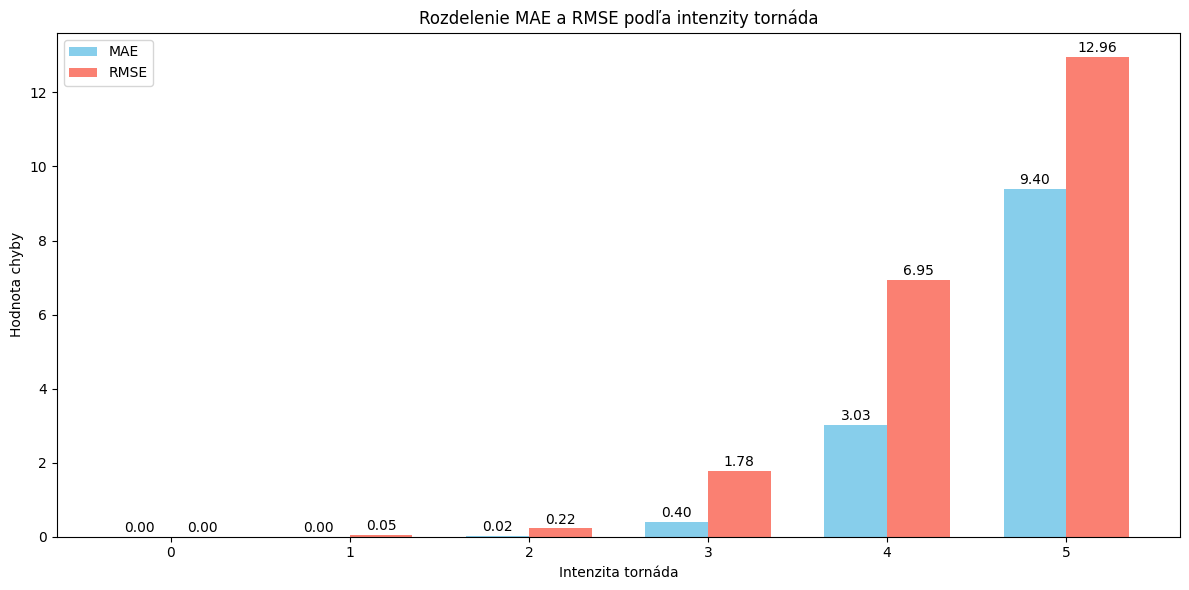

In [145]:
# Vytvorí dictionary pre uchovávanie hodnôt chýb pre jednotlivé hodnoty atribútu 'mag'
mag_errors = {}

# Cyklus pre každu intenzitu tornáda
for mag_value in test_df['mag'].unique():
    # Vyberie dáta pre danú hodnotu 'mag'
    mag_data = test_df[test_df['mag'] == mag_value]
    
    # Vypočíta Mean Absolute Error (MAE) pre túto kategóriu
    mae = mean_absolute_error(mag_data['Real_Value'], mag_data['RNF'])
    
    # Vypočíta Root Mean Squared Error (RMSE) pre túto kategóriu
    rmse = np.sqrt(mean_squared_error(mag_data['Real_Value'], mag_data['RNF']))
    
    # Uloží hodnoty chýb pre túto kategóriu do dictionary
    mag_errors[mag_value] = {'MAE': mae, 'RMSE': rmse}

# Konvertuje dictionary na DataFrame
errors_df = pd.DataFrame.from_dict(mag_errors, orient='index')

# Zoradí DataFrame podľa indexu (hodnôt atribútu 'mag')
errors_df = errors_df.sort_index()

# Vytvorí graf pre MAE a RMSE 
plt.figure(figsize=(12, 6))

# Šírka pruhov
bar_width = 0.35

# Indexy pre os x
index = errors_df.index
labels = index.tolist()
bar_index = range(len(index))

# Nakreslí stĺpce pre MAE
plt.bar(bar_index, errors_df['MAE'], bar_width, color='skyblue', label='MAE')

# Nakreslí stĺpce pre RMSE
plt.bar([i + bar_width for i in bar_index], errors_df['RMSE'], bar_width, color='salmon', label='RMSE')

plt.xlabel('Intenzita tornáda')
plt.ylabel('Hodnota chyby')
plt.title('Rozdelenie MAE a RMSE podľa intenzity tornáda')
plt.xticks([i + bar_width / 2 for i in bar_index], labels)
plt.legend()

# Priradí čísla nad stĺpce pre MAE
for i, v in enumerate(errors_df['MAE']):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

# Priradí čísla nad stĺpce pre RMSE
for i, v in enumerate(errors_df['RMSE']):
    plt.text(i + bar_width, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


<h4>Vyhľadávanie optimálnych parametrov pre model KNN</h4>

In [146]:
# Definícia modelu KNN
knn_model = KNeighborsClassifier()

# Definícia množiny parametrov, ktoré budeme prehľadávať
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Počet susedov
    'weights': ['uniform', 'distance'],  # Váhovanie bodov: uniform, distance
    'p': [1, 2]  # Norma pre výpočet vzdialenosti: 1 (Manhattan), 2 (Euklidovská)
}


# Definícia metrík na vyhodnotenie modelu
scoring = {
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R^2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error)
}

# Vytvorenie GridSearchCV objektu
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring=scoring, refit='R^2', cv=5, verbose=3, n_jobs=-1)

# Vykonanie vyhľadávania parametrov
grid_search.fit(X_train, y_train)

# Najlepšie parametre a výsledky
print("Najlepšie parametre:")
print(grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Najlepšie parametre:
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}


<h4>Funkcia na slúžiaca na použitie modelu s optimálnymi parametrami na rôznych trénovacích sadách - KNN</h4>

In [147]:
def evaluate_model_knn(X_train, y_train, X_test, y_test):
    # Natrénovanie modelu pomocou najlepších parametrov
    grid_search.best_estimator_.fit(X_train, y_train)
    # Predict on the test set using the best model
    knn_pred_optimized = grid_search.best_estimator_.predict(X_test)

    # Evaluate the optimized model
    knn_rmse_optimized = np.sqrt(mean_squared_error(y_test, knn_pred_optimized))
    knn_r2_optimized = r2_score(y_test, knn_pred_optimized)
    knn_mae_optimized = mean_absolute_error(y_test, knn_pred_optimized)

    # Print metrics for the optimized model
    print("\nOptimized KNN:")
    print("RMSE:", knn_rmse_optimized)
    print("R^2:", knn_r2_optimized)
    print("MAE:", knn_mae_optimized)


<h4>Použitie funkcie </h4>

In [148]:
print("\nKNN - nevybalansovaná")
evaluate_model_knn(X_train, y_train, X_test, y_test)
print("\nKNN - OVER")
evaluate_model_knn(X_train_balance, y_train_balance, X_test, y_test)
print("\nKNN - SMOTE")
evaluate_model_knn(X_train_smote, y_train_smote,X_test, y_test)
print("\nKNN - UNDER")
evaluate_model_knn(X_train_under, y_train_under ,X_test, y_test)


KNN - nevybalansovaná

Optimized KNN:
RMSE: 0.9093807455093761
R^2: 0.29572931533301283
MAE: 0.07870958106190726

KNN - OVER

Optimized KNN:
RMSE: 1.0537776403782078
R^2: 0.05431595800992428
MAE: 0.09932043910088866

KNN - SMOTE

Optimized KNN:
RMSE: 0.9822181253023519
R^2: 0.17839326573841374
MAE: 0.09386901650362184

KNN - UNDER

Optimized KNN:
RMSE: 0.913681797783357
R^2: 0.2890516539739707
MAE: 0.08744679262191024


<h4>Spustenie modelu s najlepšími výsledkami - Nevybalansovaná - Optimalizované parametre</h4>

In [149]:
# Definícia modelu s najlepšími parametrami
knn_model_optimized = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=2)

# Trénovanie modelu na trénovacích dátach
knn_model_optimized.fit(X_train, y_train)

# Predikcia na testovacej množine pomocou optimalizovaného modelu
knn_pred_optimized = knn_model_optimized.predict(X_test)

# Vyhodnotenie modelu pomocou rôznych metrík
knn_rmse_optimized = np.sqrt(mean_squared_error(y_test, knn_pred_optimized))
knn_r2_optimized = r2_score(y_test, knn_pred_optimized)
knn_mae_optimized = mean_absolute_error(y_test, knn_pred_optimized)

# Výpis metrík pre optimalizovaný model
print("\nOptimalizovaný KNN:")
print("RMSE:", knn_rmse_optimized)
print("R^2:", knn_r2_optimized)
print("MAE:", knn_mae_optimized)



Optimalizovaný KNN:
RMSE: 0.9093807455093761
R^2: 0.29572931533301283
MAE: 0.07870958106190726


<h4>Zobrazenie RMSE a MSE na grafe</h4>

In [150]:
# Vytvorí nový DataFrame test_df zo sady príznakov X_test so stĺpcami, ktoré sú rovnaké ako v X_test
test_df = pd.DataFrame(X_test, columns=X_test.columns)  
# Pridáva stĺpec 'KNN' do test_df, ktorý obsahuje predikcie modelu KNN uložené v rf_pred_optimized
test_df['KNN'] = knn_pred_optimized  
# Pridáva stĺpec 'Real_Value' do test_df, ktorý obsahuje skutočné hodnoty cieľového atribútu uložené v y_test
test_df['Real_Value'] = y_test  

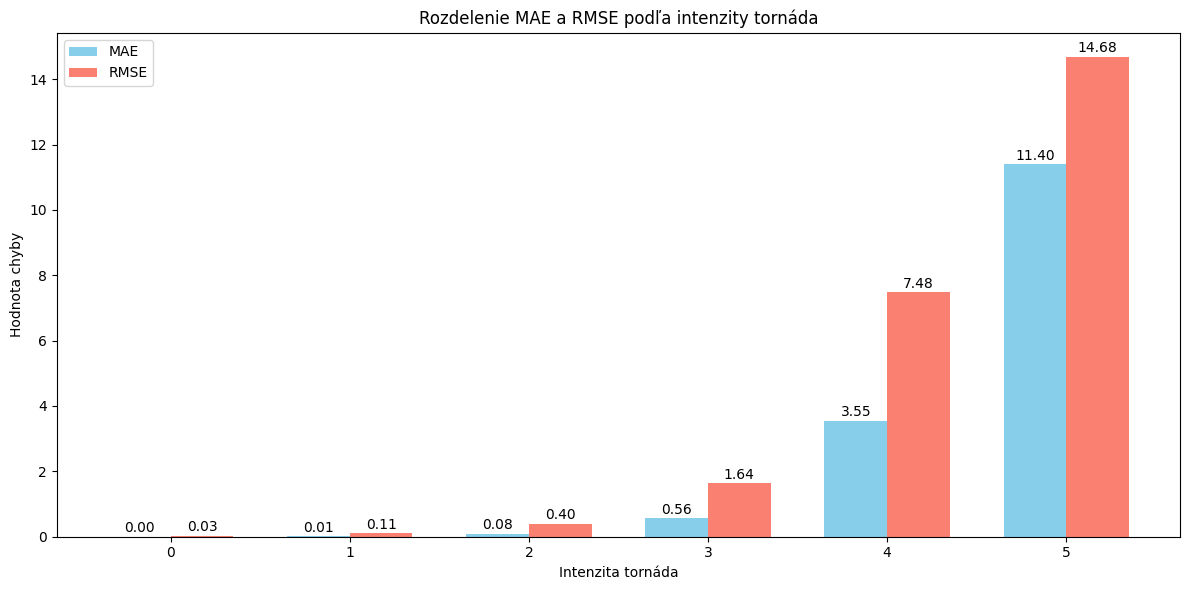

In [151]:
# Vytvorí dictionary pre uchovávanie hodnôt chýb pre jednotlivé hodnoty atribútu 'mag'
mag_errors = {}

# Cyklus pre každu intenzitu tornáda
for mag_value in test_df['mag'].unique():
    # Vyberie dáta pre danú hodnotu 'mag'
    mag_data = test_df[test_df['mag'] == mag_value]
    
    # Vypočíta Mean Absolute Error (MAE) pre túto kategóriu
    mae = mean_absolute_error(mag_data['Real_Value'], mag_data['KNN'])
    
    # Vypočíta Root Mean Squared Error (RMSE) pre túto kategóriu
    rmse = np.sqrt(mean_squared_error(mag_data['Real_Value'], mag_data['KNN']))
    
    # Uloží hodnoty chýb pre túto kategóriu do dictionary
    mag_errors[mag_value] = {'MAE': mae, 'RMSE': rmse}

# Konvertuje dictionary na DataFrame
errors_df = pd.DataFrame.from_dict(mag_errors, orient='index')

# Zoradí DataFrame podľa indexu (hodnôt atribútu 'mag')
errors_df = errors_df.sort_index()

# Vytvorí graf pre MAE a RMSE 
plt.figure(figsize=(12, 6))

# Šírka pruhov
bar_width = 0.35

# Indexy pre os x
index = errors_df.index
labels = index.tolist()
bar_index = range(len(index))

# Nakreslí stĺpce pre MAE
plt.bar(bar_index, errors_df['MAE'], bar_width, color='skyblue', label='MAE')

# Nakreslí stĺpce pre RMSE
plt.bar([i + bar_width for i in bar_index], errors_df['RMSE'], bar_width, color='salmon', label='RMSE')

plt.xlabel('Intenzita tornáda')
plt.ylabel('Hodnota chyby')
plt.title('Rozdelenie MAE a RMSE podľa intenzity tornáda')
plt.xticks([i + bar_width / 2 for i in bar_index], labels)
plt.legend()

# Priradí čísla nad stĺpce pre MAE
for i, v in enumerate(errors_df['MAE']):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

# Priradí čísla nad stĺpce pre RMSE
for i, v in enumerate(errors_df['RMSE']):
    plt.text(i + bar_width, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


<h4>Vyhľadávanie optimálnych parametrov pre model Rozhodovacie Stromy</h4>

In [152]:
# Definícia modelu Rozhodovacích stromov
dt_model = DecisionTreeClassifier(random_state=42)

# Definícia množiny parametrov na prehľadanie
param_grid = {
    'max_depth': [None, 5, 10, 15],  # Maximálna hĺbka stromu
    'min_samples_split': [2, 5, 10],  # Minimálny počet vzoriek potrebných na rozdelenie uzla
    'min_samples_leaf': [1, 2, 4]  # Minimálny počet vzoriek potrebných na list
}

# Definícia metrík na vyhodnotenie modelu
scoring = {
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R^2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error)
}

# Vytvorenie GridSearchCV objektu
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, scoring=scoring, refit='R^2', cv=5, verbose=3, n_jobs=-1)

# Vykonanie vyhľadávania parametrov
grid_search.fit(X_train, y_train)

# Najlepšie parametre a výsledky
print("Najlepšie parametre:")
print(grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Najlepšie parametre:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


<h4>Funkcia na slúžiaca na použitie modelu s optimálnymi parametrami na rôznych trénovacích sadách - Rozhodovacie Stromy</h4>

In [153]:
def evaluate_model_dt(X_train, y_train, X_test, y_test):
    # Natrénovanie modelu pomocou najlepších parametrov
    grid_search.best_estimator_.fit(X_train, y_train)
    # Predikcia na testovacej množine pomocou najlepšieho modelu
    dt_pred_optimized = grid_search.best_estimator_.predict(X_test)

    # Vyhodnotenie modelu pomocou rôznych metrík
    dt_rmse_optimized = np.sqrt(mean_squared_error(y_test, dt_pred_optimized))
    dt_r2_optimized = r2_score(y_test, dt_pred_optimized)
    dt_mae_optimized = mean_absolute_error(y_test, dt_pred_optimized)

    # Výpis metrík pre optimalizovaný model
    print("\nOptimalizované Rozhodovacie stromy:")
    print("RMSE:", dt_rmse_optimized)
    print("R^2:", dt_r2_optimized)
    print("MAE:", dt_mae_optimized)

<h4>Použitie funkcie </h4>

In [154]:
print("\nDT - nevybalansovaná")
evaluate_model_dt(X_train, y_train, X_test, y_test)
print("\nDT - OVER")
evaluate_model_dt(X_train_balance, y_train_balance, X_test, y_test)
print("\nDT - SMOTE")
evaluate_model_dt(X_train_smote, y_train_smote,X_test, y_test)
print("\nDT - UNDER")
evaluate_model_dt(X_train_under, y_train_under ,X_test, y_test)


DT - nevybalansovaná

Optimalizované Rozhodovacie stromy:
RMSE: 0.7593294976084604
R^2: 0.508969301398428
MAE: 0.05249794638189829

DT - OVER

Optimalizované Rozhodovacie stromy:
RMSE: 1.0100680536130124
R^2: 0.1311408620263339
MAE: 0.06959898439250242

DT - SMOTE

Optimalizované Rozhodovacie stromy:
RMSE: 0.7930039099869395
R^2: 0.46445155900481316
MAE: 0.06235531327010679

DT - UNDER

Optimalizované Rozhodovacie stromy:
RMSE: 0.7513212418091859
R^2: 0.5192719789238075
MAE: 0.05369277873198417


<h4>Spustenie modelu s najlepšími výsledkami - RandomUnderSampler - Optimalizované parametre</h4>

In [155]:
# Definícia modelu s najlepšími parametrami
dt_model_optimized = DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=5, random_state=42)

# Trénovanie modelu na trénovacích dátach
dt_model_optimized.fit(X_train_under, y_train_under)

# Predikcia na testovacej množine pomocou optimalizovaného modelu
dt_pred_optimized = dt_model_optimized.predict(X_test)

# Vyhodnotenie modelu pomocou rôznych metrík
dt_rmse_optimized = np.sqrt(mean_squared_error(y_test, dt_pred_optimized))
dt_r2_optimized = r2_score(y_test, dt_pred_optimized)
dt_mae_optimized = mean_absolute_error(y_test, dt_pred_optimized)

# Výpis metrík pre optimalizovaný model
print("\nOptimalizované Rozhodovacie stromy:")
print("RMSE:", dt_rmse_optimized)
print("R^2:", dt_r2_optimized)
print("MAE:", dt_mae_optimized)



Optimalizované Rozhodovacie stromy:
RMSE: 0.7513212418091859
R^2: 0.5192719789238075
MAE: 0.05369277873198417


<h4>Zobrazenie RMSE a MSE na grafe</h4>

In [156]:
# Vytvorí nový DataFrame test_df zo sady príznakov X_test so stĺpcami, ktoré sú rovnaké ako v X_test
test_df = pd.DataFrame(X_test, columns=X_test.columns)  
# Pridáva stĺpec 'DT' do test_df, ktorý obsahuje predikcie modelu Rozhodovacie Stromy uložené v rf_pred_optimized
test_df['DT'] = dt_pred_optimized  
# Pridáva stĺpec 'Real_Value' do test_df, ktorý obsahuje skutočné hodnoty cieľového atribútu uložené v y_test
test_df['Real_Value'] = y_test  

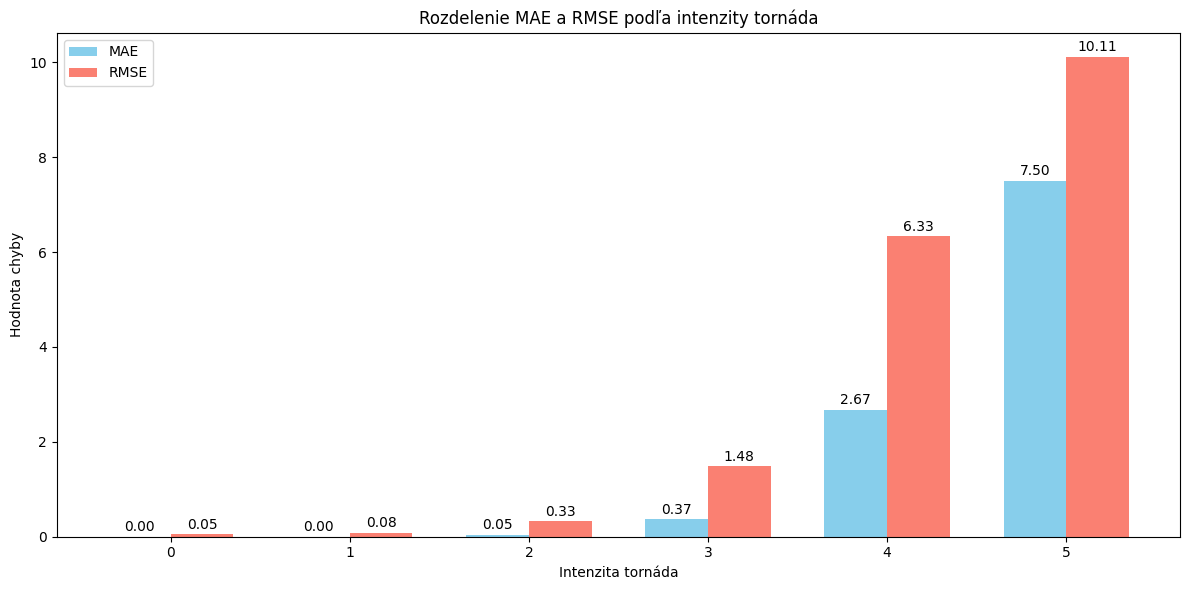

In [157]:
# Vytvorí dictionary pre uchovávanie hodnôt chýb pre jednotlivé hodnoty atribútu 'mag'
mag_errors = {}

# Cyklus pre každu intenzitu tornáda
for mag_value in test_df['mag'].unique():
    # Vyberie dáta pre danú hodnotu 'mag'
    mag_data = test_df[test_df['mag'] == mag_value]
    
    # Vypočíta Mean Absolute Error (MAE) pre túto kategóriu
    mae = mean_absolute_error(mag_data['Real_Value'], mag_data['DT'])
    
    # Vypočíta Root Mean Squared Error (RMSE) pre túto kategóriu
    rmse = np.sqrt(mean_squared_error(mag_data['Real_Value'], mag_data['DT']))
    
    # Uloží hodnoty chýb pre túto kategóriu do dictionary
    mag_errors[mag_value] = {'MAE': mae, 'RMSE': rmse}

# Konvertuje dictionary na DataFrame
errors_df = pd.DataFrame.from_dict(mag_errors, orient='index')

# Zoradí DataFrame podľa indexu (hodnôt atribútu 'mag')
errors_df = errors_df.sort_index()

# Vytvorí graf pre MAE a RMSE 
plt.figure(figsize=(12, 6))

# Šírka pruhov
bar_width = 0.35

# Indexy pre os x
index = errors_df.index
labels = index.tolist()
bar_index = range(len(index))

# Nakreslí stĺpce pre MAE
plt.bar(bar_index, errors_df['MAE'], bar_width, color='skyblue', label='MAE')

# Nakreslí stĺpce pre RMSE
plt.bar([i + bar_width for i in bar_index], errors_df['RMSE'], bar_width, color='salmon', label='RMSE')

plt.xlabel('Intenzita tornáda')
plt.ylabel('Hodnota chyby')
plt.title('Rozdelenie MAE a RMSE podľa intenzity tornáda')
plt.xticks([i + bar_width / 2 for i in bar_index], labels)
plt.legend()

# Priradí čísla nad stĺpce pre MAE
for i, v in enumerate(errors_df['MAE']):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

# Priradí čísla nad stĺpce pre RMSE
for i, v in enumerate(errors_df['RMSE']):
    plt.text(i + bar_width, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
